In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt, seaborn as sns
from sentence_transformers import SentenceTransformer, util 

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [2]:
path = "../processed/train/evaluated/paraphrase_dipper_samples_mistralai_51_EVALUATED_16_01_2024.csv"
df = pd.read_csv(path)

In [3]:
def generate_similarity_matrix(df, model, row=None):
    if row == None:
        row = np.random.randint(0, df.shape[0])
    id = df["id"][row]
    true_ending = df["text"][row]
    base_kgw_wm = df["kgw-watermarked"][row]
    base_non_wm = df["non-watermarked"][row]
    kgw_pp = [df[f"pp-kgw-{i}"][row] for i in range(1,4)]
    non_wm_pp = [df[f"pp-unwatermarked-{i}"][row] for i in range(1,4)]

    sentences = [true_ending, base_kgw_wm, base_non_wm] + kgw_pp + non_wm_pp

    embeddings = model.encode(sentences, convert_to_tensor=True)
    cosine_scores = util.cos_sim(embeddings, embeddings).cpu()
    return id, cosine_scores

In [4]:
def plot_image(cosine_scores, save=False, save_location=None):
    labels = ["true-ending", "kgw", "nwm", 
              *[f"kgw-pp-{i}" for i in range(1,4)],
              *[f"nwm-pp-{i}" for i in range(1,4)]]
    
    ax = sns.heatmap(cosine_scores, annot=True, fmt='.3f', xticklabels=labels, yticklabels=labels, vmin=0, vmax=1)
    ax.set_ylabel("Text Group")
    ax.set_xlabel("Text Group")
    ax.set_title("Sentence Similarity between Recursive Paraphrases")
    
    if save:
        if save_location == None:
            raise "Save location must be defined if saving"
        plt.savefig(save_location)
    plt.show()

In [8]:
# model = SentenceTransformer("sentence-transformers/msmarco-bert-base-dot-v5") # Long form retrieval
device = "cuda"
tokenizer = AutoTokenizer.from_pretrained("allenai/led-large-16384")
led_model = AutoModelForSeq2SeqLM.from_pretrained("allenai/led-large-16384", device_map=device)

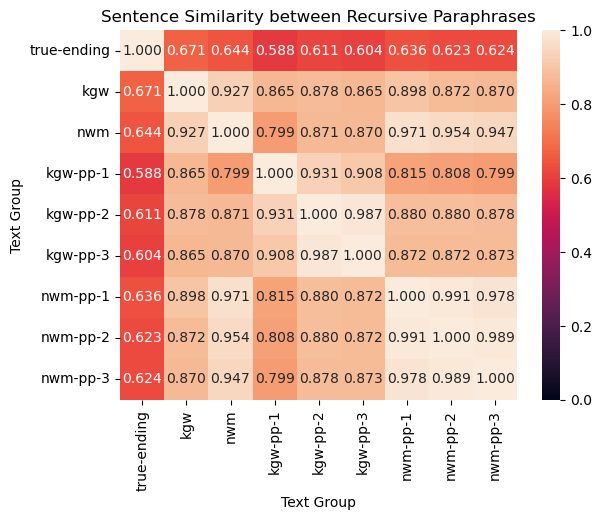

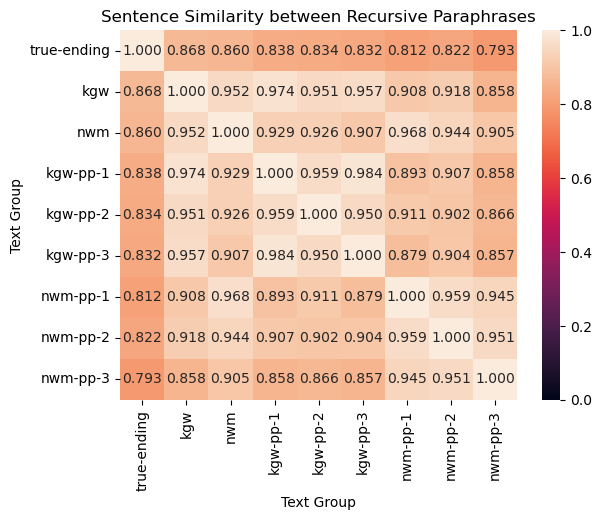

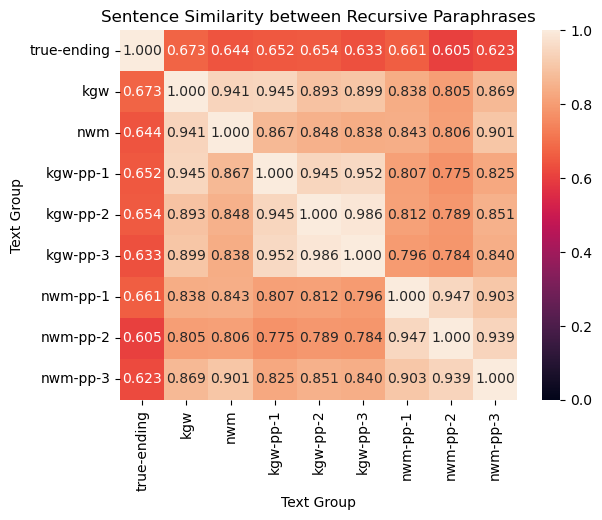

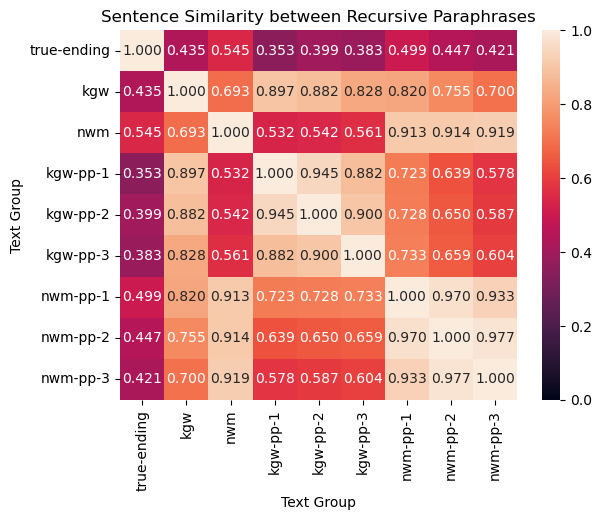

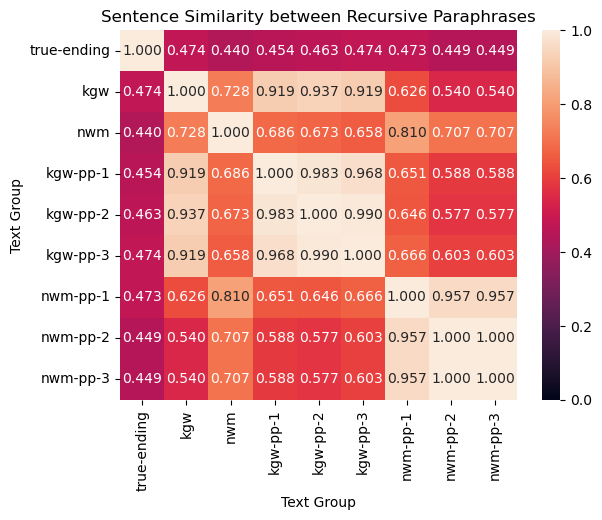

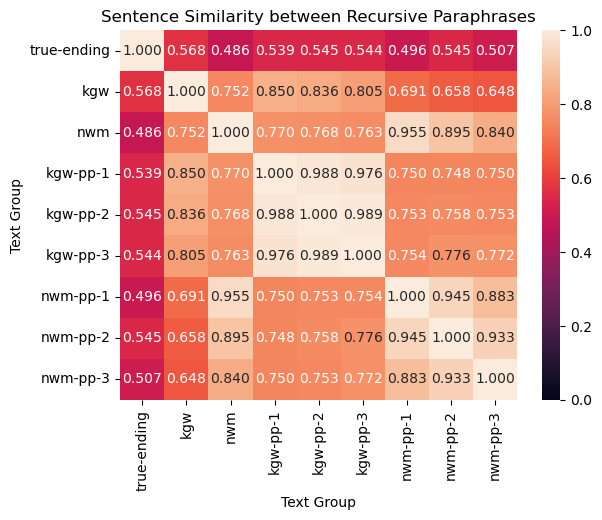

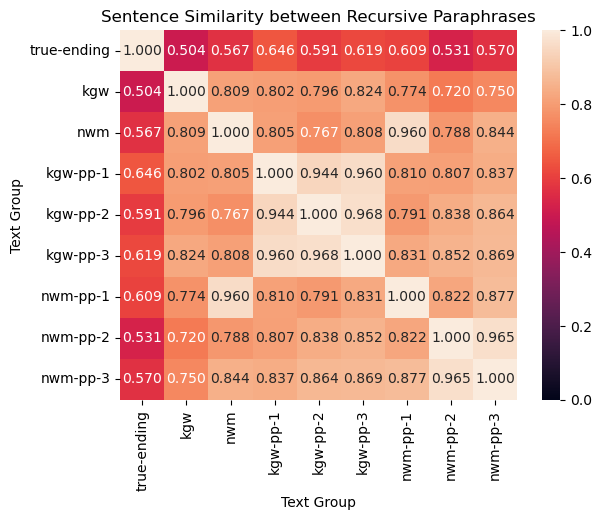

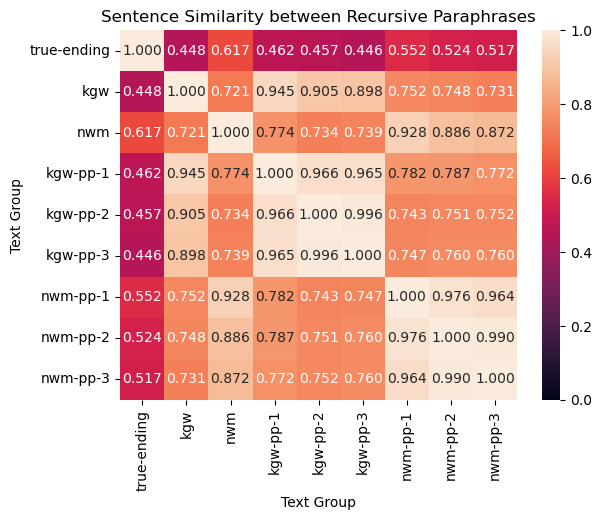

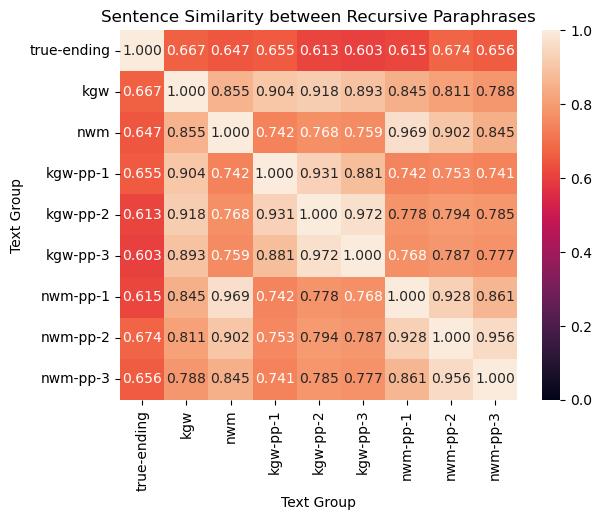

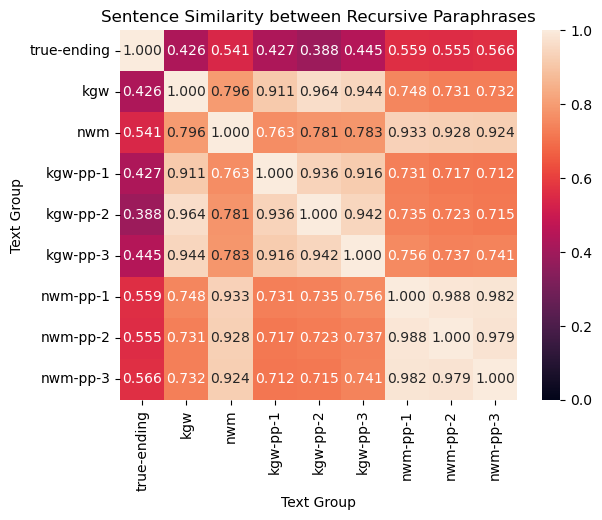

In [9]:
base_path = "../results/images/sentence_similarity/mistral-7b-january/"
for i in range(10):
    id, cosine_scores = generate_similarity_matrix(df, model)
    save_location = base_path + f"article_{id}.png"
    plot_image(cosine_scores, save=False, save_location=save_location)

In [20]:
index = 0 
prompt_length = 7
row = df.iloc[index]
kgw_text = row["kgw-watermarked"]

In [21]:
pp_tokenizer = AutoTokenizer.from_pretrained("google/t5-efficient-large-nl32")
model_path = "../code/model_finetuning/saved/google-t5-efficient-large-nl32-25_000-finetuned"
pp_model = AutoModelForSeq2SeqLM.from_pretrained(model_path, device_map="cuda")

In [22]:
def paraphrase(
        text,
        prompt_length,
        model,
        tokenizer,
        num_beams=2,
        num_beam_groups=2,
        num_return_sequences=2,
        repetition_penalty=10.0,
        diversity_penalty=3.0,
        no_repeat_ngram_size=2,
        max_length=128
):
    # Problem is that this paraphrase requires some length to be the prompt
    # No prompt does perform worse - albeit still works.
    split_words = text.split()

    # Ensures that the paragraph is 3 times longer than the prompt length at least.
    # If this is not possible, skip prompt
    # prompt = "" if len(split_words) < prompt_length*2 else " ".join(split_words[:prompt_length])
    # paragraph = " ".join(split_words) if len(prompt) == 0 else " ".join(split_words[prompt_length:])
    prompt = ""
    paragraph = text
    input_text = f"lexical = 40, order = 0 {prompt} <s> {paragraph} </s>"

    input_ids = tokenizer(
        input_text,
        return_tensors="pt", padding="longest",
        max_length=max_length,
        truncation=True,
    ).to(device).input_ids

    outputs = model.generate(
        input_ids,
        repetition_penalty=repetition_penalty,
        num_return_sequences=num_return_sequences,
        no_repeat_ngram_size=no_repeat_ngram_size,
        num_beams=num_beams,
        num_beam_groups=num_beam_groups,
        max_length=max_length,
        diversity_penalty=diversity_penalty
    )

    res = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    res = f"{prompt} {' '.join(res)}"
    return res

In [25]:
kgw_text = "Title: The Fallacy of First Impressions: A Change Can Happen\n\nThe notion that first impressions are inaccurate and susceptible to change pervades various aspects of modern life. In my experience, a friend judged another acquaintance unfavorably upon their initial meeting, attributing arrogance to the latter's poised demeanor. Yet, over time and numerous encounters, the truth unfolded – the individual exhibited humility, compassion, and depth exceeding any expectations (Lee, 2006). Research indicates that people's first impressions can differ significantly after subsequent interactions. For instance, a scientific journal published by Taylor & Fiske revealed findings of numerous studies demonstrating that both physical appearance ratings and personality assessments change as relationships develop, debunking the belief in the infallibility of first impressions. In conclusion, the complex process of human judgment makes the accuracy of first impressions questionable while emphasizing the importance of ongoing interactions."

In [26]:
response = paraphrase(kgw_text, prompt_length, pp_model, pp_tokenizer)
print(f"{kgw_text} \n\n {response}")

lexical = 40, order = 0  <s> Title: The Fallacy of First Impressions: A Change Can Happen

The notion that first impressions are inaccurate and susceptible to change pervades various aspects of modern life. In my experience, a friend judged another acquaintance unfavorably upon their initial meeting, attributing arrogance to the latter's poised demeanor. Yet, over time and numerous encounters, the truth unfolded – the individual exhibited humility, compassion, and depth exceeding any expectations (Lee, 2006). Research indicates that people's first impressions can differ significantly after subsequent interactions. For instance, a scientific journal published by Taylor & Fiske revealed findings of numerous studies demonstrating that both physical appearance ratings and personality assessments change as relationships develop, debunking the belief in the infallibility of first impressions. In conclusion, the complex process of human judgment makes the accuracy of first impressions questio